In [1]:
import os
import io
import requests
import time
import boto3
import json
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
font = {'weight': 'bold'
       ,'size': 16}
plt.rc('font', **font)
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error,r2_score, make_scorer, roc_auc_score
from sklearn.metrics import roc_curve, auc, recall_score
from matplotlib.ticker import PercentFormatter, StrMethodFormatter

In [2]:
def poll_job(s, redash_url, job):
    """ Example code adopted from https://github.com/getredash/redash-toolbelt/blob/master/redash_toolbelt/examples/refresh_query.py
    Args:
        s (Request Session): A session from HTTP requests library
        redash_url: Url of the Redash website to use
        job: json job returned from the session response

    Returns:
        None
        Polls Redash API for a query result
    """
    while job['status'] not in (3,4):
        response = s.get(f"{redash_url}/api/jobs/{job['id']}")
        job = response.json()['job']
        time.sleep(1)

    if job['status'] == 3:
        return job['query_result_id']
    
    return None

In [3]:
def get_fresh_query_result(redash_url, query_id, api_key, params):
    """ Example code adopted from https://github.com/getredash/redash-toolbelt/blob/master/redash_toolbelt/examples/refresh_query.py
    Args:
        redash_url (str): Url of the Redash website to use
        query_id (int): Unique identifier of the query stored in Redash system
        api_key (str): The Redash user's unique API key
        params (dict): A dictionary of optional parameters to use in the format key = Param Name, value = Param value

    Returns:
        None
        Polls Redash API for a query result
    """
    s = requests.Session()
    s.headers.update({'Authorization': f"Key {api_key}"})

    payload = dict(max_age=0, parameters=params)

    response = s.post(f"{redash_url}/api/queries/{query_id}/results", data = json.dumps(payload))

    if response.status_code != 200:
        raise Exception('Refresh failed.')

    result_id = poll_job(s, redash_url, response.json()['job'])

    if result_id:
        response = s.get(f"{redash_url}/api/queries/{query_id}/results/{result_id}.json")
        if response.status_code != 200:
            raise Exception('Failed getting results.')
    else:
        raise Exception('Query execution failed.')

    return response.json()['query_result']['data']['rows']


In [4]:
params = {'p_param': ''}
query_id = 732436
api_key = os.environ['REDASH_API_KEY']
link = os.environ['REDASH_LINK']
query_results = get_fresh_query_result(link, query_id, api_key, params)
query_df = pd.DataFrame(query_results)

In [6]:
query_df.columns = [col.lower() for col in query_df.columns.tolist()]
query_df.month_date = pd.to_datetime(query_df.month_date)

pre_covid = query_df[query_df.month_date < '2020-03-01']
post_covid = query_df[query_df.month_date >= '2020-03-01']

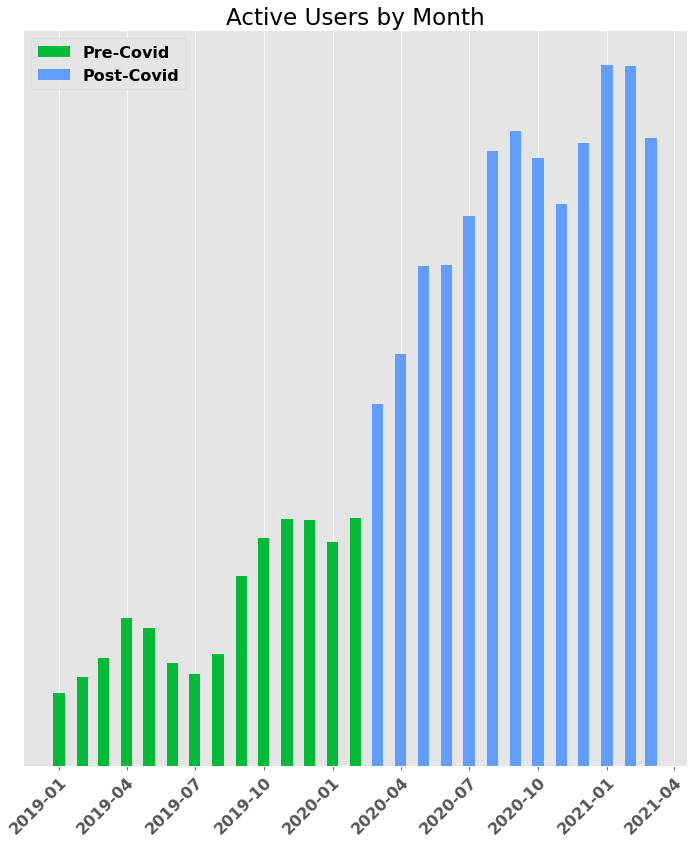

In [125]:
fig, ax = plt.subplots(figsize=(10,12))

ax.bar(x=pre_covid.month_date, height=pre_covid.active_users, width=15, color='#00BA38', label='Pre-Covid')
ax.bar(x=post_covid.month_date, height=post_covid.active_users, width=15, color='#619CFF', label='Post-Covid')
ax.set_title("Active Users by Month")
ax.legend(loc='upper left')
ax.get_yaxis().set_visible(False)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right', rotation_mode="anchor")
plt.tight_layout();
plt.savefig("../images/active_user_growth.png", dpi=400)

In [16]:
params = {'p_param': ''}
query_id = 714507
api_key = os.environ['REDASH_API_KEY']
link = os.environ['REDASH_LINK']
churn_results = get_fresh_query_result(link, query_id, api_key, params)
churn_df = pd.DataFrame(churn_results)

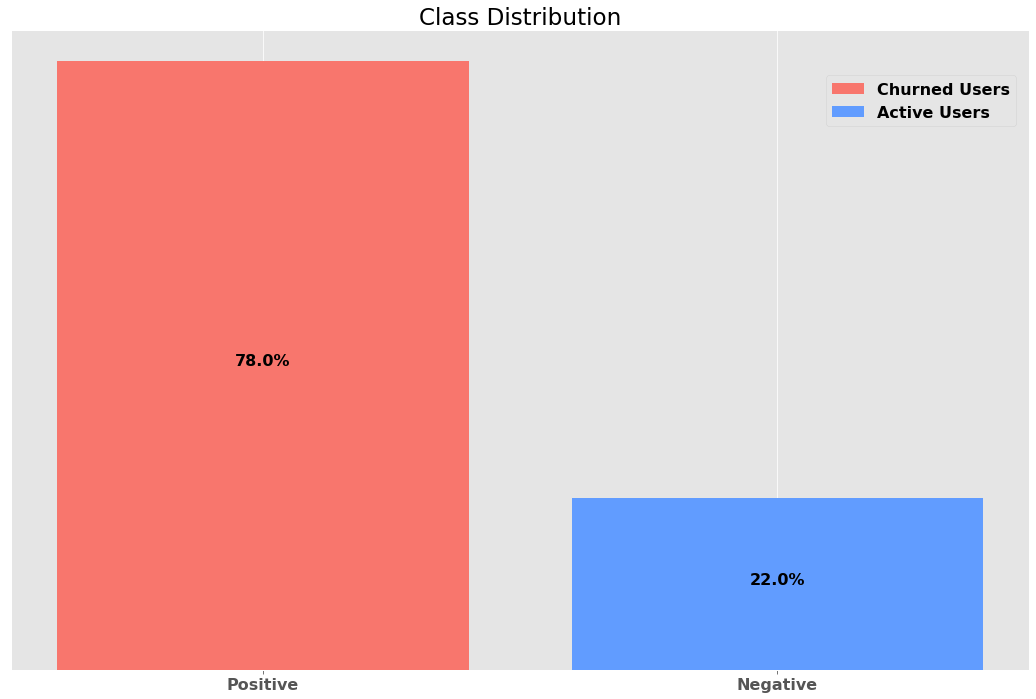

In [122]:
churn = churn_df[churn_df.churned_user == True].shape[0]
active = churn_df[churn_df.churned_user == False].shape[0]

fig, ax = plt.subplots(figsize=(15,10))
ax.bar(x='Positive', height=churn, color='#F8766D', label="Churned Users")
ax.bar(x='Negative', height = active, color='#619CFF', label="Active Users")
ax.text(x='Positive', y=churn/2, s=str(f"{churn/churn_df.shape[0]:.1%}"), ha='center')
ax.text(x='Negative', y=active/2, s=str(f"{active/churn_df.shape[0]:.1%}"), ha='center')
ax.set_title("Class Distribution")
ax.legend(loc=(0.8, 0.85))
ax.get_yaxis().set_visible(False);
plt.tight_layout()
plt.savefig("../images/class_distribution.png")

In [18]:
churn_df.columns = [col.lower() for col in churn_df.columns.tolist()]
churn_df.signup_time_utc = pd.to_datetime(churn_df.signup_time_utc)
churn_df.last_order_time_utc = pd.to_datetime(churn_df.last_order_time_utc)
churn_df.first_order_delivered_on_time = churn_df.first_order_delivered_on_time.astype(bool)
# churn_df['first_order_discount_percent'] = churn_df.first_order_discount_amount / churn_df.first_order_gmv
signup_date = churn_df.signup_time_utc.map(lambda x: x.floor('D'))
churn_df['days_since_signup'] = (pd.to_datetime('today').floor('D') - signup_date).map(lambda x: x.days)
churn_date = pd.to_datetime('today').floor('D') - pd.Timedelta(days=30)
churn_df['churned_user'] = churn_df.last_order_time_utc.map(lambda x: True if x < churn_date else False)

In [19]:
real_cities = churn_df.city_name.sort_values().unique().tolist()
got_cities = ["King's Landing"
             ,"Braavos"
             ,"Qarth"
             ,"Old Valyria"
             ,"Volantis"
             ,"Asshai"
             ,"Meereen"
             ,"Astapor"
             ,"Old Ghis"
             ,"Oldtown"
             ,"Pentos"
             ,"Qohor"
             ,"Sathar"
             ,"Sunspear"
             ,"Lannisport"
             ,"Vaes Dothrak"
             ,"White Harbor"
             ,"Yunkai"
             ,"The Wall"
             ,"Ghozi"
             ,"Gulltown"
             ,"Lys"
             ,"Mantarys"
             ,"Tyria"
             ,"Tolos"
             ,"Samyrian"
             ,"Oros"
             ,"Norvos"]
got_cities.sort()
city_dict = dict(zip(real_cities, got_cities))
churn_df.city_name = churn_df.city_name.map(city_dict)

In [20]:
kde_columns = churn_df.select_dtypes(include=[np.number, 'boolean']).drop('user_id', axis=1)
target = kde_columns.pop('churned_user')
values = kde_columns.iloc[:,0]
values[target == False]
kde_columns

,days_since_signup,signup_to_order_hours,first_order_driver_rating,first_order_avg_meal_rating,first_order_meal_reviews,first_order_delivered_on_time,first_order_hours_late,first_order_gmv,first_order_discount_percent,first_order_driver_tips,first_30_day_orders,first_30_day_avg_driver_rating,first_30_day_avg_meal_rating,first_30_day_avg_gmv,first_30_day_discount_percent,first_30_day_avg_driver_tips,first_30_day_subscription_user,first_30_day_support_messages
0,360,2737.816667,4,4.00,2,True,0.0,50.470000,0.098871,0.00,8,4.5,4.00000,55.697500,0.112483,1.500000,False,256
1,250,2.083333,-1,-1.00,-1,True,0.0,63.130000,0.079043,1.00,7,-1.0,4.50000,37.885714,0.131712,1.285714,True,224
2,245,173.283333,-1,-1.00,-1,True,0.0,72.460000,0.124068,8.28,6,5.0,4.43750,92.748333,0.073568,5.978333,True,384
3,69,48.550000,-1,-1.00,-1,True,0.0,52.821500,0.245951,5.92,31,5.0,4.59375,56.674906,0.072480,6.988387,True,2077
4,343,18.283333,-1,4.67,3,True,0.0,47.100000,0.106157,6.42,1,-1.0,4.67000,47.100000,0.106157,6.420000,False,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177534,350,6221.250000,-1,-1.00,-1,True,0.0,154.868700,0.059849,16.75,1,-1.0,-1.00000,154.868700,0.059849,16.750000,False,41
177535,75,450.600000,-1,3.20,5,True,0.0,51.265664,0.407814,5.72,1,-1.0,3.20000,51.265664,0.407814,5.720000,False,5
177536,359,741.066667,-1,-1.00,-1,True,0.0,53.650000,0.116496,5.00,1,-1.0,-1.00000,53.650000,0.116496,5.000000,False,-1
177537,210,166.333333,-1,-1.00,-1,True,0.0,173.882800,0.427373,20.80,1,-1.0,-1.00000,173.882800,0.427373,20.800000,False,30


In [43]:
kde_data = churn_df.select_dtypes(include=[np.number, 'boolean']).drop('user_id', axis=1)
kde_cols = kde_data.iloc[:,:kde_data.shape[1] - 1].columns.to_list()
kde_data.loc[:,['first_30_day_orders','days_since_signup', 'signup_to_order_hours', 'churned_user']]

,first_30_day_orders,days_since_signup,signup_to_order_hours,churned_user
0,8,360,2737.816667,True
1,7,250,2.083333,True
2,6,245,173.283333,True
3,31,69,48.550000,False
4,1,343,18.283333,True
...,...,...,...,...
177534,1,350,6221.250000,True
177535,1,75,450.600000,True
177536,1,359,741.066667,True
177537,1,210,166.333333,True


In [44]:
sig_kde = kde_data.loc[:,['first_30_day_orders','days_since_signup', 'signup_to_order_hours', 'churned_user']]
sig_kde.columns.tolist()

['first_30_day_orders',
 'days_since_signup',
 'signup_to_order_hours',
 'churned_user']

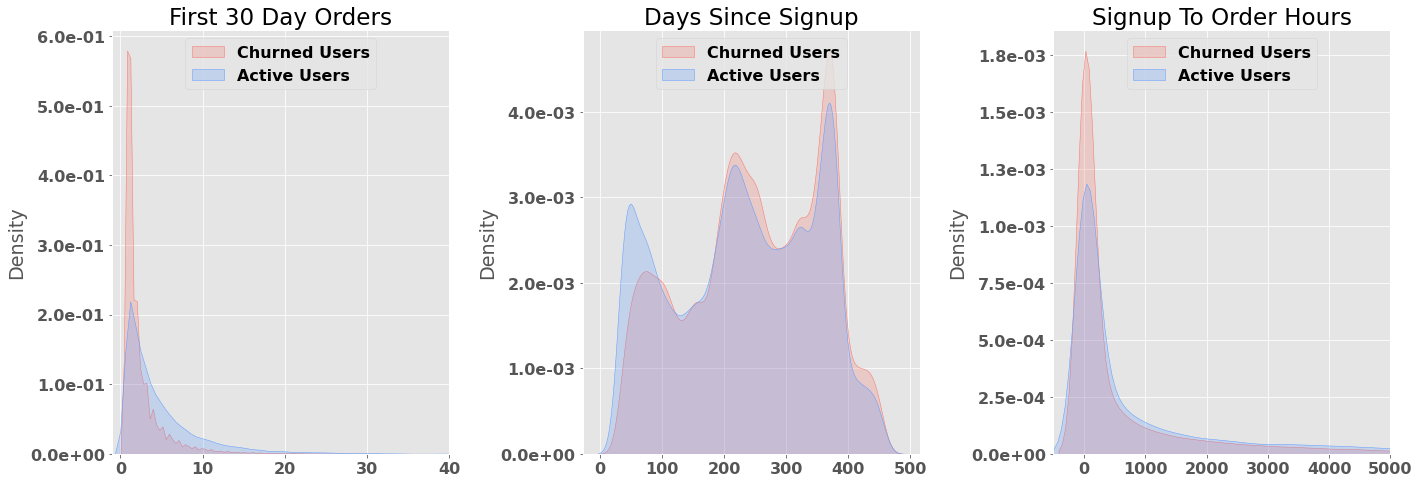

In [128]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,7))

for col, ax in zip(sig_kde.columns.tolist(), axs.flatten()):
    
    churn = sig_kde[sig_kde.churned_user == True]
    active = sig_kde[sig_kde.churned_user == False]

    sns.kdeplot(churn[col], fill=True, bw_method=0.1, color='#F8766D', label='Churned Users', ax=ax)
    sns.kdeplot(active[col], fill=True, bw_method=0.1, color='#619CFF', label='Active Users', ax=ax)
    ax.set_xlabel('')
    if col == 'first_30_day_orders':
        ax.set_xlim(left=-1, right=40)
    elif col == 'signup_to_order_hours':
        ax.set_xlim(left=-500, right=5000)
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1e}'))
    ax.set_title(col.replace('_', ' ').title())
    ax.legend(loc='upper center')

# if len(kde_cols) % 2 == 1:
#     fig.delaxes(axs[np.ceil(len(kde_cols)/2).astype(int)-1,1])
    
plt.tight_layout()
# plt.suptitle("Top 3 Predictors",y=0.95, fontsize=25)
plt.savefig("../images/top_3_predictors.png", dpi=400)

In [62]:
non_sig_kde = kde_data.loc[:,['first_30_day_subscription_user','first_order_driver_rating', 'first_order_delivered_on_time', 'churned_user']]
non_sig_kde.columns.tolist()

['first_30_day_subscription_user',
 'first_order_driver_rating',
 'first_order_delivered_on_time',
 'churned_user']

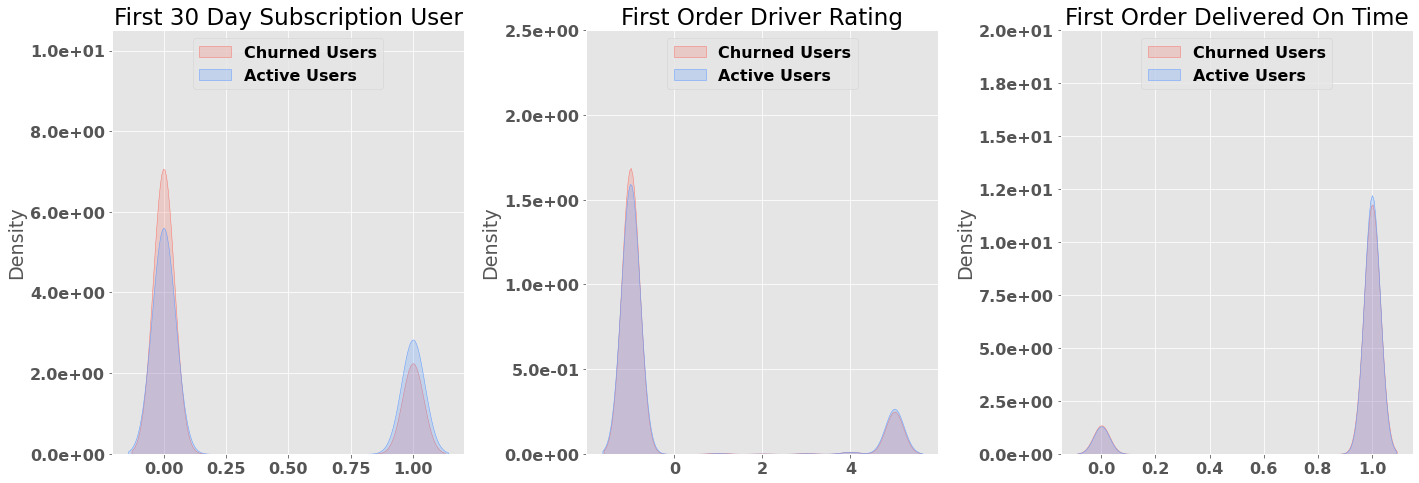

In [129]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20,7))

for col, ax in zip(non_sig_kde.columns.tolist(), axs.flatten()):
    
    churn = non_sig_kde[non_sig_kde.churned_user == True]
    active = non_sig_kde[non_sig_kde.churned_user == False]

    sns.kdeplot(churn[col], fill=True, bw_method=0.1, color='#F8766D', label='Churned Users', ax=ax)
    sns.kdeplot(active[col], fill=True, bw_method=0.1, color='#619CFF', label='Active Users', ax=ax)
    ax.set_xlabel('')
    if col == 'first_30_day_subscription_user':
        ax.set_ylim(top=10.5)
    elif col == 'first_order_driver_rating':
        ax.set_ylim(top=2.5)
    else:
        ax.set_ylim(top=20.0)
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1e}'))
    ax.set_title(col.replace('_', ' ').title())
    ax.legend(loc='upper center')

# if len(kde_cols) % 2 == 1:
#     fig.delaxes(axs[np.ceil(len(kde_cols)/2).astype(int)-1,1])
    
plt.tight_layout()
# plt.suptitle("Bottom 3 Predictors",y=1.03, fontsize=25)
plt.savefig("../images/bottom_3_predictors.png", dpi=400)

In [60]:
categorical_data = churn_df.select_dtypes(include=['object'])
categorical_data = pd.concat([categorical_data, churn_df.churned_user], axis=1)
len(categorical_data.columns.tolist()[:-1])

2

In [11]:
cat_data = churn_df[['city_name', 'city_group', 'churned_user']]
cat_cols = cat_data.iloc[:,:cat_data.shape[1] - 1].columns.to_list()

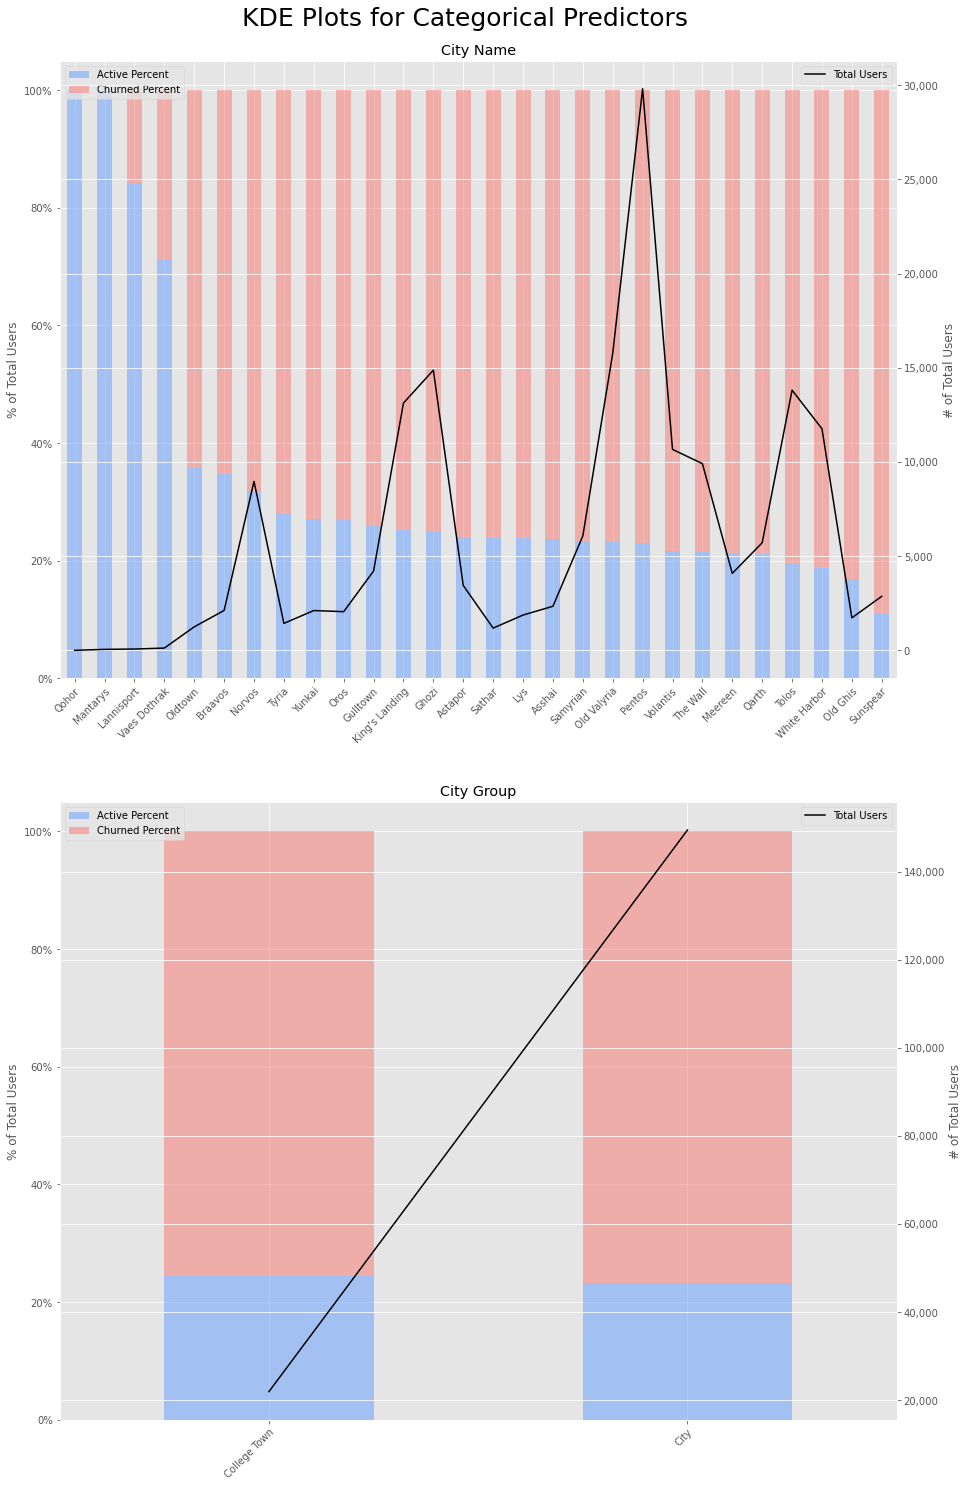

In [12]:
fig, axs = plt.subplots(nrows=np.ceil(len(cat_cols)).astype(int), ncols=1, figsize=(15,25))

for col, ax in zip(cat_cols[:len(cat_cols)], axs.flatten()):

    group_data = cat_data.groupby([col, 'churned_user']).size().unstack()
    group_data.columns = ['Active Users', 'Churned Users']
    group_data = group_data.fillna(value=0)
    group_data['Total Users'] = group_data['Active Users'] + group_data['Churned Users']
    group_data['Active Percent'] = group_data['Active Users'] / group_data['Total Users']
    group_data['Churned Percent'] = group_data['Churned Users'] / group_data['Total Users']
    total_users = group_data.sort_values('Active Percent', ascending=False)['Total Users']
    city_churn = group_data[['Active Percent', 'Churned Percent']].sort_values('Active Percent', ascending=False)
    city_churn.plot.bar(stacked=True, ax=ax, color=['#619CFF', '#F8766D'], alpha = 0.5)
    ax2 = ax.twinx()
    total_users.plot(color='black', ax=ax2)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right', rotation_mode="anchor")
    ax.set_xlabel('')
    ax.set_title(col.replace('_', ' ').title())
    ax.set_ylabel('% of Total Users')
    ax2.set_ylabel('# of Total Users')
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0))
    ax2.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')

_ = plt.suptitle("KDE Plots for Categorical Predictors",y=0.91, fontsize=25)

In [19]:
y = churn_df.pop('churned_user')
X = churn_df

In [20]:
churn_data_Xy = pd.concat([X, y], axis=1)
churn_train, churn_test = train_test_split(churn_data_Xy, test_size=0.2, shuffle=True, stratify=y)

In [21]:
churn_train.to_csv('churn_train.csv', index=False)

In [10]:
aws_id = os.environ['AWS_ACCESS_KEY_ID']
aws_secret = os.environ['AWS_SECRET_ACCESS_KEY']
client = boto3.client('s3'
                     ,aws_access_key_id=aws_id
                     ,aws_secret_access_key=aws_secret)
client.upload_file(Filename='churn_train.csv', Bucket='food-delivery-churn', Key='churn_train.csv')

In [11]:
train_obj = client.get_object(Bucket='food-delivery-churn', Key='churn_train.csv')
churn_train_X = pd.read_csv(io.BytesIO(train_obj['Body'].read())
                            ,encoding='utf8'
                            ,parse_dates=['signup_time_utc', 'last_order_time_utc']
                            ,date_parser=pd.to_datetime)